# **TEST IMPLEMENTAZIONE VELOCITY RESCALING**

---

Velocity rescaling: riscalare la velocità durante la fase di termalizzazione per forzare il sistema a stabilizzarsi attorno a quella $T$. La fase di termalizzazione diventa _isocinetica_, non è fisica. Aiuta a simulare alte temperature senza dover partire da $T_{ini}$ intrattabili.

$$
\vec{v}_i(t) \to \vec{v}_i(t) \sqrt\frac{T_\text{want}}{T(t)}
$$

### 0) Importazioni e dati

In [1]:
import numpy as np
from CMS.MolecularDynamics.CrystalStructure import CrystalStructure as Crystal
from CMS.MolecularDynamics.CrystalDynamics import CrystalDynamics


In [2]:
# Nome del file (numero di atomi da studiare: 256)
filename = '../../../data/pos-fcc100-minime/C_s=5e-4~F_t=5e-4~max_s=50k/fcc100a256_1.txt'

#### Dati globali

In [3]:
# boundaries della cella da studiare (crystal slab)
# pbc = [16.6416, 16.6416, np.inf]  # in Å
pbc = [16.6416, 16.6416, 166_416] 

# temperature da studiare
temperatura = [2000, 1000]

# massa atomica dell'atomo considerato (argento)
silver_mass = 108

# time step ottimale per 1000K
time_step = 3e-15 

# il numero di step è dato dal tempo totale (100ps) diviso il time step
tempo_totale = 100e-12
n_steps = int(tempo_totale / time_step)

# devo includere energie TERMALIZZAZIONE
t_th = 3e-12

#### Inizializzazione del cristallo

In [4]:
# Inizializzo il cristallo dal file minimizzato con steepest-descent
cristallo = Crystal.from_file(filename)
# Setto il raggio di cutoff E la giunzione polinomiale
cristallo.set_R_C(4.5)
cristallo.set_R_P(4.2)
cristallo.set_R_V(5.0)
# Setto le condizioni al contorno periodiche (vanno settate DOPO R_C)
cristallo.set_pbc(pbc)

#### Aggiunta di un atomo in superficie al centro e a +2.4 Å dal massimo z

In [5]:
# prendo il massimo z di tutti gli atomi
massimo_z = np.max(cristallo.positions[:, 2])
# calcolo il centro del cristallo nelle direzioni x e y
centro_x, centro_y, _ = cristallo.crystal_center
# posiziono l'atomo ad una distanza di 2.4 Å sopra il massimo z
cristallo.add_atom([centro_x, centro_y, massimo_z + 2.4])

# 16.6416 è dimensione della cella, poi traslo in base all'origine
origine = np.min(cristallo.positions, axis=0)
#cristallo.add_atom([16.6416/2 + origine[0], 16.6416/2 + origine[1], massimo_z + 2.4])

### 1) Simulazione di 100ps a T = 1000 K CON E SENZA RESCALING

In [6]:
result = {}

In [7]:
for T in temperatura:
    print(f"🚀 Avvio simulazione a T={T} K")
    # Raccolgo le energie medie e le dev std
    simulazione = CrystalDynamics(
        cristallo.copy(), 
        atomic_mass=silver_mass, 
        dt=time_step, 
        temp_ini=T)  
    simulazione.set_seed(12316543)

    # stavolta output True per visualizzare con ovito
    result[T] = simulazione.run_dynamics(
        n_steps=n_steps, 
        t_th=t_th,
        rescale_velocity=True if T == 1000 else False,
        include_thermalization_in_output=True
    )

🚀 Avvio simulazione a T=2000 K
🚀 Avvio simulazione a T=1000 K


### 2) Analisi e plot

Alcuni dati della simulazione

In [8]:
for T in temperatura:
    print(f"Risultati per T={T} K")
    result[T].summary()

Risultati per T=2000 K
Simulation Result:
 - Duration: 103.00 ps
 - Mean Temp: 995.32 ± 39.47 K
 - Mean Energy: -478.45 ± 0.00 eV

Risultati per T=1000 K
Simulation Result:
 - Duration: 103.00 ps
 - Mean Temp: 1044.48 ± 40.17 K
 - Mean Energy: -474.66 ± 0.93 eV



## Termalizzazione a confronto

### Energia

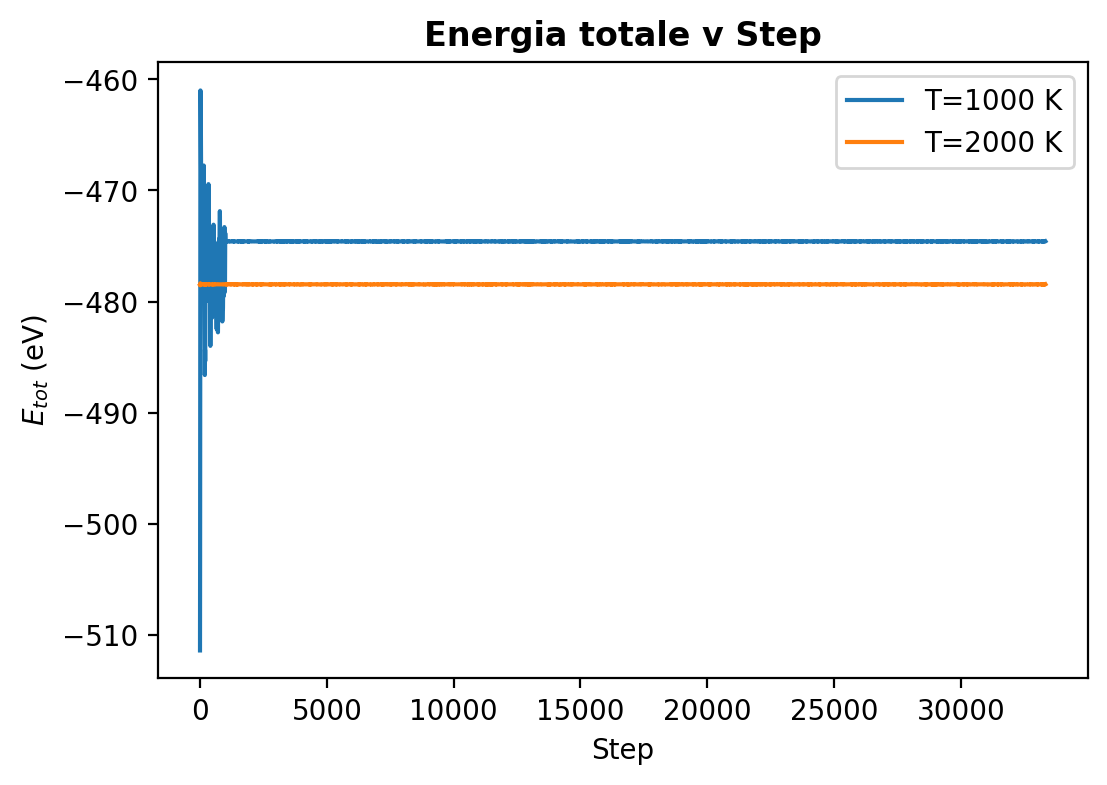

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 4), dpi=200)

x1 = range(len(result[1000].energies['total']))

plt.plot(x1, result[1000].energies['total'], label="T=1000 K")   
plt.plot(x1, result[2000].energies['total'], label="T=2000 K")
plt.xlabel("Step")
plt.ylabel(r'$E_{tot}$ (eV)')
plt.legend()
plt.title("Energia totale v Step", fontweight='bold')
plt.show()

### Temperatura

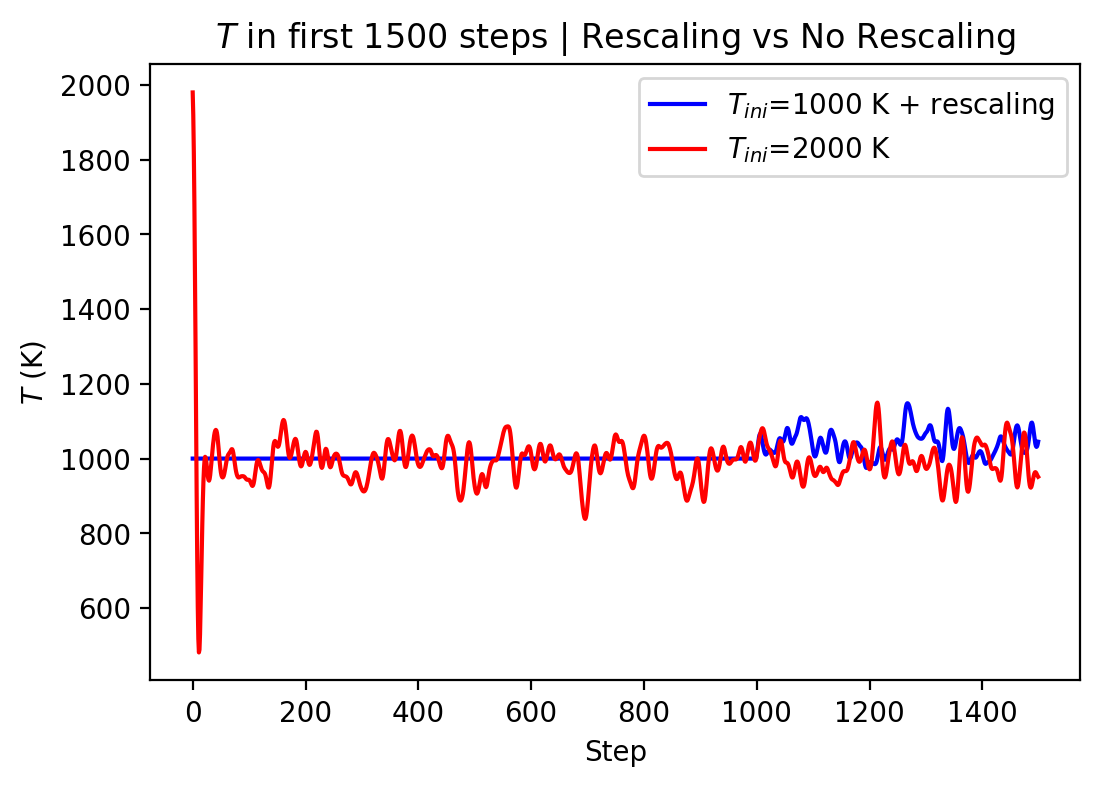

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 4), dpi=200)

x1 = range(len(result[1000].temperatures[:1500]))

plt.plot(x1, result[1000].temperatures[:1500], label="$T_{ini}$=1000 K + rescaling", color='blue')   
plt.plot(x1, result[2000].temperatures[:1500], label="$T_{ini}$=2000 K", color='red')
plt.xlabel("Step")
plt.ylabel(r'$T$ (K)')
plt.legend()
plt.title("$T$ in first 1500 steps | Rescaling vs No Rescaling")
plt.show()